Downloading the Data from the Website !

In [2]:
import requests
def download_data():
    url = "https://hastie.su.domains/ElemStatLearn/datasets/prostate.data"
    response = requests.get(url)
    f = open('prostate.data', 'wb')
    f.write(response.content)
    f.close()
# download_data()

Splitting the Data and Scaling!

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
SEED  = 1
np.random.seed(SEED)
def split_data():
    DATA = pd.read_csv('prostate.data', sep='\s+')
    train_data = DATA[DATA.iloc[:, -1] == 'T'].values
    test_data = DATA[DATA.iloc[:, -1] == 'F'].values
    y_train = train_data[:, -2]
    y_test = test_data[:, -2]
    X_train = train_data[:, :-2]
    X_test = test_data[:, :-2]
    return X_train, X_test, y_train, y_test,DATA
X_train, X_test, y_train,y_test,DATA = split_data()
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train) #using the X_train as the scaled one as discussed in the report !
X_test_scaled = sc.transform(X_test) #Also using the X_test_scaled as discussed in the report !

kfold = KFold(n_splits=10, shuffle=True,random_state=SEED) # to make sure that when we use cross_validation the model is going to split them randomly, which cross_val_score doesn't do unless we specify the method we want like we are doing here ! But even now I am getting weird ranges 

OLS 

In [4]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

OLS = LinearRegression() 
OLS.fit(X_train_scaled, y_train)
y_pred = OLS.predict(X_test_scaled)
'''STD ERROR'''
OLS_STD_ERROR = y_pred.std()/np.sqrt(len(y_pred))

'''TEST ERROR'''
OLS_TEST_ERROR = mean_squared_error(y_test, y_pred)

Ridge Regression

In [16]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 
X_train_scaled_float = X_train_scaled.astype(np.float64)
'''Finding the lambdas as discussed in the report !'''
U, d, Vt = np.linalg.svd(X_train_scaled_float)
s = 0
for D in d: 
    s += D**2/(D**2)
lambdas_RIDGE = [4000,400,150,75,40,22,12,5,0]

'''Finding the best df ( or lambda)'''


RIDGE_CV_ERROR = [] 
TEST_ERROR_RIDGE = []
RIDGE_RANGE_CV = []
RIDGE_COEF = []
for lamb in lambdas_RIDGE:
    Pipe = Pipeline([('scaler', StandardScaler()), ('RIDGE', Ridge(alpha=lamb,fit_intercept=True,solver='svd'))])
    model = Ridge(alpha=lamb,fit_intercept=True,solver='svd',random_state=SEED)
    
    SCORES_PIPE = cross_val_score(model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=kfold) # here it is better practice to use Pipe, to scale each fold in the CV before training it, but I won't do that in order to get the same result as the picture in the book ! Which based on my observation did not use this strategy, they only relied on the initial scaled data 
    SCORES_PIPE = - SCORES_PIPE
    RIDGE_CV_ERROR.append(SCORES_PIPE.mean())
    model.fit(X_train_scaled, y_train)
    #Getting the test_error
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    TEST_ERROR_RIDGE.append(mse)
    #Getting the range of the CV
    RIDGE_RANGE_CV.append((np.max(SCORES_PIPE), np.min(SCORES_PIPE)))
    RIDGE_COEF.append(model.coef_)
RIDGE_COEF = np.array(RIDGE_COEF)
MIN_RIDGE_INDEX = 0
for i in range(len(TEST_ERROR_RIDGE)):
    if TEST_ERROR_RIDGE[i]<TEST_ERROR_RIDGE[MIN_RIDGE_INDEX]:
        MIN_RIDGE_INDEX = i

X_AXIS_RIDGE = np.arange(0,9,1)


RIDGE_model = Ridge(alpha=lambdas_RIDGE[MIN_RIDGE_INDEX], fit_intercept=True, solver='svd', random_state=SEED)
RIDGE_model.fit(X_train_scaled, y_train)
y_pred = RIDGE_model.predict(X_test_scaled)
'''Getting the STD ERROR of the (lowest test error ) model'''


RIDGE_STD_ERROR = y_pred.std()/np.sqrt(len(y_pred))


'''TEST ERROR of the lowest TEST ERROR CALCULATED ABOVE'''
RIDGE_TEST_ERROR = mean_squared_error(y_test, y_pred)


'''Vertical Line'''
RIDGE_VERTICAL_LINE = X_AXIS_RIDGE[MIN_RIDGE_INDEX]

'''Horizontal Line'''
RIDGE_HORIZONTAL_LINE = RIDGE_CV_ERROR[MIN_RIDGE_INDEX]

[15.15186295 10.45809199  8.33410584  6.43638252  5.52262052  5.02380897
  4.3310785   3.41596048]
[[8.18535277 4.48503547 4.37992304 2.0572402  6.30298277 6.80932346
  5.34506715 5.68962309]
 [4.48503547 8.18535277 4.6065684  5.41126445 3.48290827 3.24152986
  1.25634386 2.22915758]
 [4.37992304 4.6065684  8.18535277 4.38773425 2.93878404 3.4040775
  4.95139508 4.29871886]
 [2.0572402  5.41126445 4.38773425 8.18535277        nan        nan
  1.48676635        nan]
 [6.30298277 3.48290827 2.93878404        nan 8.18535277 6.70619818
  4.53438529 5.67899363]
 [6.80932346 3.24152986 3.4040775         nan 6.70619818 8.18535277
  5.64989097 6.66256216]
 [5.34506715 1.25634386 4.95139508 1.48676635 4.53438529 5.64989097
  8.18535277 7.12199307]
 [5.68962309 2.22915758 4.29871886        nan 5.67899363 6.66256216
  7.12199307 8.18535277]]


C:\Users\Admin\AppData\Local\Temp\ipykernel_7560\128477433.py:11: RuntimeWarning: invalid value encountered in sqrt
  print(np.sqrt(np.dot(X_train_scaled.T,X_train_scaled)))


Lasso 

In [6]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression 

'''Finding the lambdas as discussed in the report for the Lasso model !'''
tempo_model = LinearRegression()
tempo_model.fit(X_train_scaled, y_train)
DENOMINATOR = np.sum(np.abs(tempo_model.coef_))
NUMERATOR = np.sum(np.abs(Lasso(alpha=0.88,fit_intercept=True,random_state=SEED).fit(X_train_scaled,y_train).coef_))
s = NUMERATOR/DENOMINATOR
lambdas_LASSO = [0.88,0.6544,0.4385,0.3020,0.1885,0.1068,0.0452,0.0335,0.0217,0.00999,0]

'''Finding the best df ( or lambda)'''
LASSO_CV_ERROR = [] 
TEST_ERROR_LASSO = []
LASSO_RANGE_CV = []
LASSO_COEF = []
for lamb in lambdas_LASSO:
    if lamb !=0:
        lasso_model = Lasso(alpha=lamb, fit_intercept=True, random_state=SEED)
        
        SCORES_model = cross_val_score(lasso_model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=kfold) 
        #same analysis as in Ridge Regression for using the Pipe !
        SCORES_model = -SCORES_model

        LASSO_CV_ERROR.append(SCORES_model.mean())
        lasso_model.fit(X_train_scaled, y_train)
        #Getting the test_error
        mse = mean_squared_error(y_test, lasso_model.predict(sc.transform(X_test)))
        TEST_ERROR_LASSO.append(mse)
        '''adding the min and max value that we got from the cross validation score'''
        LASSO_RANGE_CV.append((np.max(SCORES_model),np.min(SCORES_model)))
        LASSO_COEF.append(lasso_model.coef_)
    else:#we did this just because the Lasso model of sklearn gives us warning that the algorithm might not converge at alpha = 0, but we know that at alpha = 0, it is just the same as the OLS, so we will use the OLS 
        tmp_model = LinearRegression()
        SCORES_tmp = cross_val_score(tmp_model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=kfold)
        SCORES_tmp = -SCORES_tmp
        LASSO_CV_ERROR.append(SCORES_tmp.mean())
        tmp_model.fit(X_train_scaled, y_train)
        mse = mean_squared_error(y_test, tmp_model.predict(sc.transform(X_test)))
        TEST_ERROR_LASSO.append(mse)
        LASSO_RANGE_CV.append((np.max(SCORES_tmp), np.min(SCORES_tmp)))
        LASSO_COEF.append(tmp_model.coef_)
LASSO_COEF = np.array(LASSO_COEF)
MIN_LASSO_INDEX = 0
for i in range(len(TEST_ERROR_LASSO)):
    if TEST_ERROR_LASSO[i] < TEST_ERROR_LASSO[MIN_LASSO_INDEX]:
        MIN_LASSO_INDEX = i
X_AXIS_LASSO = np.arange(0,1.1,0.1)
lasso_model = Lasso(alpha=lambdas_LASSO[MIN_LASSO_INDEX], fit_intercept=True, random_state=SEED)
lasso_model.fit(X_train_scaled, y_train)
y_pred = lasso_model.predict(X_test_scaled)
'''Getting the STD ERROR of the (lowest test error ) model'''


LASSO_STD_ERROR = y_pred.std()/np.sqrt(len(y_pred))

'''Finding the LOWEST test error which we found previously'''
LASSO_TEST_ERROR = mean_squared_error(y_test, y_pred)
print(LASSO_TEST_ERROR)
'''Vertical Line'''
LASSO_VERTICAL_LINE = X_AXIS_LASSO[MIN_LASSO_INDEX] 

'''Horizontal Line'''
LASSO_HORIZONTAL_LINE = LASSO_CV_ERROR[MIN_LASSO_INDEX]

0.4523336775011796


Best Subset Selection !

In [7]:
from sklearn.linear_model import LinearRegression
from itertools import combinations
from sklearn.metrics import mean_squared_error
from itertools import combinations
from sklearn.model_selection import cross_val_score
# The PCA Class usually takes care of centering the X_train but not scaling for each feature before applying the SVD. But as we explained in the introduction of the report we are going to pass the X_train_scaled so now the PCA won't do anything before applying the SVD
X_AXIS_BSS = np.arange(0,9,1)
BSS_CV_ERROR = []   
TEST_ERROR_BSS = []
BSS_RANGE_CV = []
BEST_SUBSET = []
features = np.arange(0,8,1)
for k in X_AXIS_BSS:
    if k !=0:
        best_subset  = []
        best_subset_score = -np.inf
        for subset in combinations(features, k):
            linear_model = LinearRegression()
            X_train_subset = X_train_scaled[:, subset]
            X_test_subset = X_test_scaled[:, subset]
            
            linear_model.fit(X_train_subset, y_train)
            r_2_score = linear_model.score(X_train_subset, y_train) 
            
            #### Here we will choose the best model based on the R^2
            
            
            if r_2_score > best_subset_score:
                best_subset_score = r_2_score
                best_subset = subset
    
        tmp = LinearRegression()
        X_train_subset = X_train_scaled[:, best_subset]
        X_test_subset = X_test_scaled[:, best_subset]
        SCORES = -cross_val_score(tmp, X_train_subset, y_train, scoring='neg_mean_squared_error', cv=kfold)
        BSS_CV_ERROR.append(SCORES.mean())
        BSS_RANGE_CV.append((np.max(SCORES),(np.min(SCORES))))
        tmp.fit(X_train_subset, y_train)
        TEST_ERROR_BSS.append(mean_squared_error(y_test, tmp.predict(X_test_subset)))
        BEST_SUBSET.append(best_subset)
    else:
        #if k == 0 then same analysis as pca we will fit a null model !!! ( which we will have as the same value in pca when n_of_components = 0)
        MEAN_1 = np.full(len(y_train), np.mean(y_train))
        MEAN_2 = np.full(len(y_test), np.mean(y_train))
        # MEAN_1 and MEAN_2 are the same they just differs in the length !!
        TEST_ERROR_BSS.append(mean_squared_error(y_test, MEAN_2))
        BEST_SUBSET.append([])
        ## Getting the range Now !
        

        '''Creating manually the CV since there is no a null model so we will create it '''
        ARR  = []
        for train_index, test_index in kfold.split(X_train_scaled):
            y_train_1, y_test_1 = y_train[train_index], y_train[test_index] 
            y_pred_1 = np.full(shape=y_test_1.shape, fill_value=y_train_1.mean())
            score = mean_squared_error(y_test_1, y_pred_1)
            ARR.append(score)
        ARR = np.array(ARR)
        BSS_CV_ERROR.append(ARR.mean())
        BSS_RANGE_CV.append((np.max(ARR), (np.min(ARR))))


MIN_BSS_INDEX = np.argmin(TEST_ERROR_BSS)-1 # Getting the minimum index of this array,  taking the least closest model within one std error as per the picture and this is indicated by !
INDEX_OF_SUBSET = BEST_SUBSET[MIN_BSS_INDEX]
BSS_MODEL = LinearRegression()
BSS_MODEL.fit(X_train_scaled[:,INDEX_OF_SUBSET], y_train)

y_pred = BSS_MODEL.predict(X_test_scaled[:, INDEX_OF_SUBSET])
'''TEST ERROR'''
BSS_TEST_ERROR = mean_squared_error(y_test, y_pred)
'''Getting the STD ERROR of the (lowest test error ) model'''
BSS_STD_ERROR  = y_pred.std()/np.sqrt(len(y_pred))
'''Vertical Line'''
BSS_VERTICAL_LINE = X_AXIS_BSS[MIN_BSS_INDEX]
'''Horizontal Line'''
BSS_HORIZONTAL_LINE = BSS_CV_ERROR[MIN_BSS_INDEX+1] #to get back the lowest test error which is represented by the horizontal line !!!

PCR

In [8]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# The PCA Class usually takes care of centering the X_train but not scaling for each feature before applying the SVD. But as we explained in the introduction of the report we are going to pass the X_train_scaled so now the PCA won't do anything before applying the SVD
X_AXIS_PCR = np.arange(0,9,1)
PCR_CV_ERROR = []   
TEST_ERROR_PCR = []
PCR_RANGE_CV = []
for n in X_AXIS_PCR:
    if n!=0:
        pca = PCA(n_components=n,random_state=SEED) 
        
        pcr_model = LinearRegression()
        pipeline = Pipeline([('pca', pca),('linreg', pcr_model)])
        
        SCORES_PCR = cross_val_score(pipeline, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=kfold)
        SCORES_PCR = -SCORES_PCR
        PCR_CV_ERROR.append(SCORES_PCR.mean())
        PCR_RANGE_CV.append((np.max(SCORES_PCR),(np.min(SCORES_PCR))))
        
        #Getting the test_error
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)
        pcr_model.fit(X_train_pca, y_train)
        mse = mean_squared_error(y_test, pcr_model.predict(X_test_pca))
        TEST_ERROR_PCR.append(mse)
    else:
        #The case where n_components is equal to zero
        #Since we can't actually fit a linear model with 0 features (in sklearn), in general this is equivalent to the null model, which just predicts y based on the mean of the training data (y_train) so that is what we are going to do.
        MEAN_1 = np.full(len(y_train), np.mean(y_train))
        MEAN_2 = np.full(len(y_test), np.mean(y_train))
        # MEAN_1 and MEAN_2 are the same they just differs in the length 
        
        TEST_ERROR_PCR.append(mean_squared_error(y_test, MEAN_2))
        '''Creating manually the CV since there is no a null model so we will create it '''
        ARR  = []
        for train_index, test_index in kfold.split(X_train_scaled):
            y_train_1, y_test_1 = y_train[train_index], y_train[test_index] 
            y_pred_1 = np.full(shape=y_test_1.shape, fill_value=y_train_1.mean())
            score = mean_squared_error(y_test_1, y_pred_1)
            ARR.append(score)
        ARR = np.array(ARR)
        PCR_CV_ERROR.append(ARR.mean())
        PCR_RANGE_CV.append((np.max(ARR), (np.min(ARR))))
MIN_PCR_INDEX = 0
for i in range(len(TEST_ERROR_PCR)):
    if TEST_ERROR_PCR[i] < TEST_ERROR_PCR[MIN_PCR_INDEX]:
        MIN_PCR_INDEX = i
        


pca = PCA(n_components=X_AXIS_PCR[MIN_PCR_INDEX], random_state=SEED)
X_train_pca = pca.fit_transform(X_train_scaled)
pcr_model = LinearRegression()
pcr_model.fit(X_train_pca, y_train)
X_test_pca = pca.transform(X_test_scaled)

'''Getting the STD ERROR of the (lowest test error ) model'''

y_pred = pcr_model.predict(X_test_pca)
PCR_STD_ERROR  = y_pred.std()/np.sqrt(len(y_pred))

'''GEtting the test error back (the lowest one)'''

PCR_TEST_ERROR = mean_squared_error(y_test, y_pred)

'''Vertical Line'''
PCR_VERTICAL_LINE = X_AXIS_PCR[MIN_PCR_INDEX] # the less complex model within the std error

'''Horizontal Line'''
PCR_HORIZONTAL_LINE = PCR_CV_ERROR[MIN_PCR_INDEX]

Getting the PCR COEF ! ( See report for more details) !

In [9]:
pcr_coef = np.dot(pca.components_.T, pcr_model.coef_) #See details in the report of how we got this !

THE RANGE OF EACH MODEL AND FOR EACH CV (i.e. the blue intervals on the picture)

Figure 3.7 without ranges !

[]

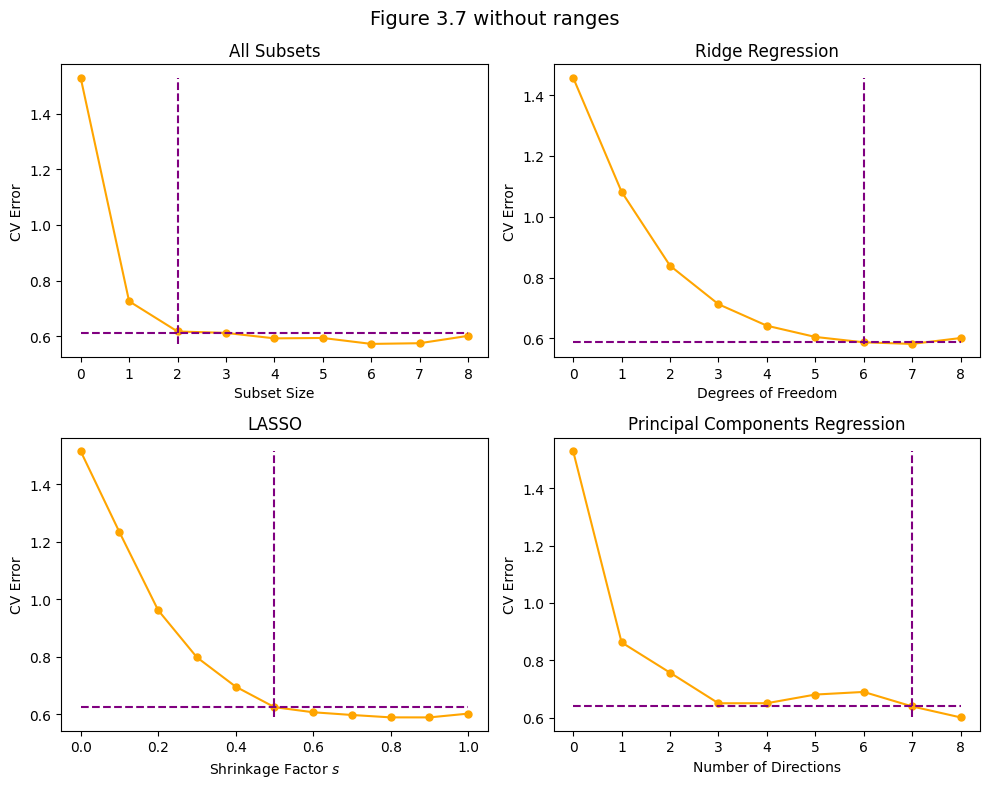

In [10]:

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Figure 3.7 without ranges', fontsize=14)
fig.subplots_adjust(top=0.88)
axs[1,0].plot(X_AXIS_LASSO, LASSO_CV_ERROR, label='LASSO CV Error', marker='o', linestyle='-', markersize=5, markerfacecolor='orange', color = 'orange')
axs[1,0].vlines(LASSO_VERTICAL_LINE, ymin = min(LASSO_CV_ERROR), ymax = max(LASSO_CV_ERROR), color = 'purple', linestyles='--')
axs[1,0].hlines(LASSO_HORIZONTAL_LINE, xmin = min(X_AXIS_LASSO), xmax = max(X_AXIS_LASSO), color = 'purple', linestyles='--')
axs[1,0].set_title('LASSO')
axs[1,0].set_xlabel('Shrinkage Factor $s$')
axs[1,0].set_ylabel('CV Error')



axs[0,1].plot(X_AXIS_RIDGE, RIDGE_CV_ERROR, label='Ridge CV Error', marker='o', linestyle='-', markersize=5, markerfacecolor='orange', color = 'orange')
axs[0,1].vlines(RIDGE_VERTICAL_LINE, ymin = min(RIDGE_CV_ERROR), ymax = max(RIDGE_CV_ERROR), color = 'purple', linestyles='--')
axs[0,1].hlines(RIDGE_HORIZONTAL_LINE, xmin = min(X_AXIS_RIDGE), xmax = max(X_AXIS_RIDGE), color = 'purple', linestyles='--')
axs[0,1].set_title('Ridge Regression')
axs[0,1].set_xlabel('Degrees of Freedom')
axs[0,1].set_ylabel('CV Error')


axs[1,1].plot(X_AXIS_PCR, PCR_CV_ERROR, label='PCR CV Error', marker='o', linestyle='-', markersize=5, markerfacecolor='orange', color = 'orange')
axs[1,1].vlines(PCR_VERTICAL_LINE, ymin = min(PCR_CV_ERROR), ymax = max(PCR_CV_ERROR), color = 'purple', linestyles='--')
axs[1,1].hlines(PCR_HORIZONTAL_LINE, xmin = min(X_AXIS_PCR), xmax = max(X_AXIS_PCR), color = 'purple', linestyles='--')
axs[1,1].set_title('Principal Components Regression')
axs[1,1].set_xlabel('Number of Directions')
axs[1,1].set_ylabel('CV Error')


axs[0,0].plot(X_AXIS_BSS,BSS_CV_ERROR,label='BSS CV Error',marker='o',linestyle='-',markersize=5,markerfacecolor='orange',color='orange')
axs[0,0].vlines(BSS_VERTICAL_LINE, ymin = min(BSS_CV_ERROR), ymax = max(BSS_CV_ERROR), color = 'purple', linestyles='--')
axs[0,0].hlines(BSS_HORIZONTAL_LINE, xmin = min(X_AXIS_BSS), xmax = max(X_AXIS_BSS), color = 'purple', linestyles='--')
axs[0,0].set_title('All Subsets')
axs[0,0].set_xlabel('Subset Size')
axs[0,0].set_ylabel('CV Error')

plt.tight_layout()
plt.plot()

Figure 3.7 with ranges !

[]

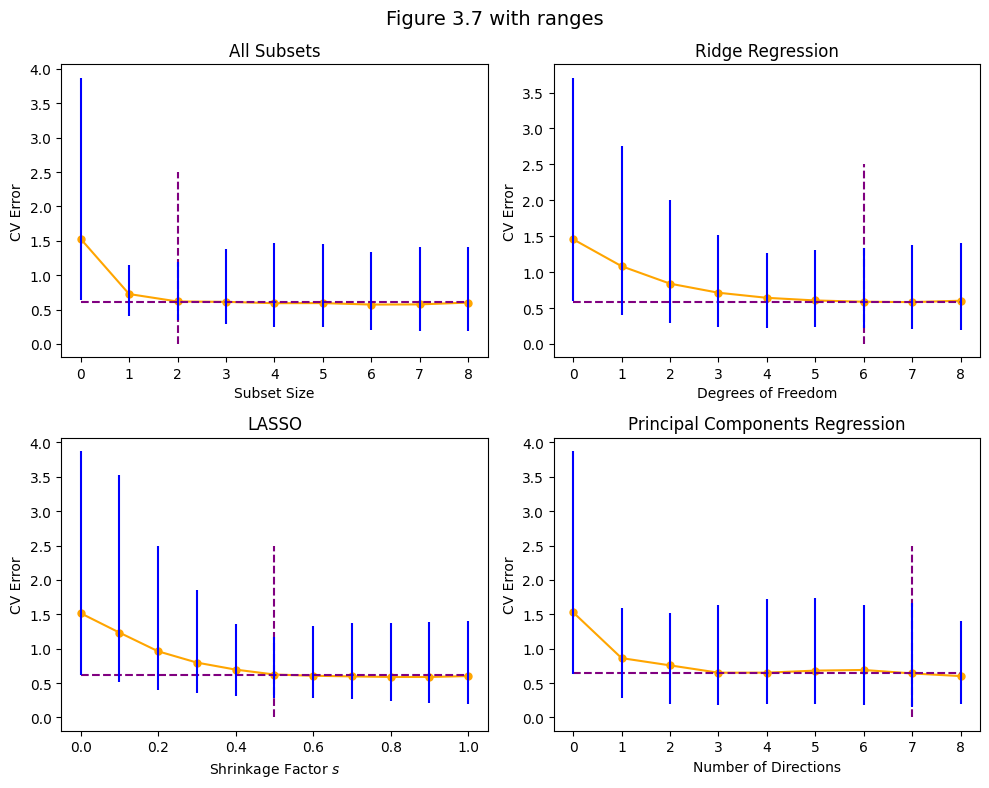

In [11]:

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Figure 3.7 with ranges', fontsize=14)
fig.subplots_adjust(top=0.88)
axs[1,0].plot(X_AXIS_LASSO, LASSO_CV_ERROR, label='LASSO CV Error', marker='o', linestyle='-', markersize=5, markerfacecolor='orange', color = 'orange')
axs[1,0].vlines(LASSO_VERTICAL_LINE, ymin = 0, ymax = 2.5, color = 'purple', linestyles='--')
axs[1,0].hlines(LASSO_HORIZONTAL_LINE, xmin = min(X_AXIS_LASSO), xmax = max(X_AXIS_LASSO), color = 'purple', linestyles='--')
axs[1,0].set_title('LASSO')
axs[1,0].set_xlabel('Shrinkage Factor $s$')
axs[1,0].set_ylabel('CV Error')
for i,x in enumerate(X_AXIS_LASSO):
    axs[1,0].vlines(x,ymin =LASSO_RANGE_CV[i][1] ,ymax=LASSO_RANGE_CV[i][0],color = 'blue',linestyles = '-')

axs[0,1].plot(X_AXIS_RIDGE, RIDGE_CV_ERROR, label='Ridge CV Error', marker='o', linestyle='-', markersize=5, markerfacecolor='orange', color = 'orange')
axs[0,1].vlines(RIDGE_VERTICAL_LINE, ymin = 0, ymax =2.5, color = 'purple', linestyles='--')
axs[0,1].hlines(RIDGE_HORIZONTAL_LINE, xmin = min(X_AXIS_RIDGE), xmax = max(X_AXIS_RIDGE), color = 'purple', linestyles='--')
axs[0,1].set_title('Ridge Regression')
axs[0,1].set_xlabel('Degrees of Freedom')
axs[0,1].set_ylabel('CV Error')
for i,x in enumerate(X_AXIS_RIDGE):
    axs[0,1].vlines(x, ymin =RIDGE_RANGE_CV[i][1], ymax=RIDGE_RANGE_CV[i][0], color = 'blue', linestyles = '-')

axs[1,1].plot(X_AXIS_PCR, PCR_CV_ERROR, label='PCR CV Error', marker='o', linestyle='-', markersize=5, markerfacecolor='orange', color = 'orange')
axs[1,1].vlines(PCR_VERTICAL_LINE, ymin = 0, ymax = 2.5, color = 'purple', linestyles='--')
axs[1,1].hlines(PCR_HORIZONTAL_LINE, xmin = min(X_AXIS_PCR), xmax = max(X_AXIS_PCR), color = 'purple', linestyles='--')
axs[1,1].set_title('Principal Components Regression')
axs[1,1].set_xlabel('Number of Directions')
axs[1,1].set_ylabel('CV Error')
for i,x in enumerate(X_AXIS_PCR):
    axs[1,1].vlines(x, ymin =PCR_RANGE_CV[i][1], ymax=PCR_RANGE_CV[i][0], color = 'blue', linestyles = '-')

axs[0,0].plot(X_AXIS_BSS,BSS_CV_ERROR,label='BSS CV Error',marker='o',linestyle='-',markersize=5,markerfacecolor='orange',color='orange')
axs[0,0].vlines(BSS_VERTICAL_LINE, ymin = 0, ymax = 2.5, color = 'purple', linestyles='--')
axs[0,0].hlines(BSS_HORIZONTAL_LINE, xmin = min(X_AXIS_BSS), xmax = max(X_AXIS_BSS), color = 'purple', linestyles='--')
axs[0,0].set_title('All Subsets')
axs[0,0].set_xlabel('Subset Size')
axs[0,0].set_ylabel('CV Error')

for i,x in enumerate(X_AXIS_BSS):
    axs[0,0].vlines(x, ymin =BSS_RANGE_CV[i][1], ymax=BSS_RANGE_CV[i][0], color = 'blue', linestyles = '-')
plt.tight_layout()
plt.plot()

Table 3.3 

In [12]:

import pandas as pd
OLS_terms = np.concatenate((np.array([OLS.intercept_]) ,OLS.coef_))
OLS_terms = np.append(OLS_terms, OLS_TEST_ERROR)
OLS_terms = np.append(OLS_terms, OLS_STD_ERROR)

RIDGE_terms = np.concatenate((np.array([RIDGE_model.intercept_]), RIDGE_model.coef_))
RIDGE_terms = np.append(RIDGE_terms, RIDGE_TEST_ERROR)
RIDGE_terms = np.append(RIDGE_terms, RIDGE_STD_ERROR)
print(LASSO_TEST_ERROR)
print(RIDGE_TEST_ERROR)
Lasso_terms = np.concatenate((np.array([lasso_model.intercept_]), lasso_model.coef_))
Lasso_terms = np.append(Lasso_terms, LASSO_TEST_ERROR)
Lasso_terms = np.append(Lasso_terms, LASSO_STD_ERROR)

pcr_terms = np.concatenate((np.array([pcr_model.intercept_]), pcr_coef))
pcr_terms = np.append(pcr_terms, PCR_TEST_ERROR)
pcr_terms = np.append(pcr_terms, PCR_STD_ERROR)
'''BSS'''


D = {}
Coef = BSS_MODEL.coef_
count = 0
for i,ind in enumerate(INDEX_OF_SUBSET):
    D[ind] = Coef[count]
    count +=1

bss_terms = [BSS_MODEL.intercept_]
for i in range(0,len(X_train_scaled[0])):
    if i in D:
        bss_terms.append(D[i])
    else:
        bss_terms.append(0)
bss_terms.append(BSS_TEST_ERROR)
bss_terms.append(BSS_STD_ERROR)

D = {"Term":["Intercept","lcavol","lweight","age","lbph","svi","lcp","gleason","pgg45","Test Error","Std Error"],"OLS":OLS_terms,"Best Subset":bss_terms,"RIDGE":RIDGE_terms,"LASSO":Lasso_terms,"PCR":pcr_terms}

df = pd.DataFrame(data=D)

df.set_index("Term", inplace=True)


latex_code = df.to_latex(index=True, header=True)
print(df)


0.4523336775011796
0.4872727403710508
                 OLS  Best Subset     RIDGE     LASSO       PCR
Term                                                           
Intercept   2.452345     2.452345  2.452345  2.452345  2.452345
lcavol      0.711041     0.774017  0.517054  0.569856  0.566307
lweight     0.290450     0.349274  0.271865  0.226034  0.320860
age        -0.141482     0.000000 -0.078536 -0.000000 -0.152568
lbph        0.210420     0.000000  0.186844  0.098608  0.214382
svi         0.307300     0.000000  0.259546  0.166214  0.319707
lcp        -0.286841     0.000000 -0.068079  0.000000 -0.050024
gleason    -0.020757     0.000000  0.030533  0.000000  0.226861
pgg45       0.275268     0.000000  0.162426  0.061197 -0.063150
Test Error  0.521274     0.492482  0.487273  0.452334  0.448309
Std Error   0.131771     0.130864  0.126833  0.116512  0.146816


Figure 3.8

[]

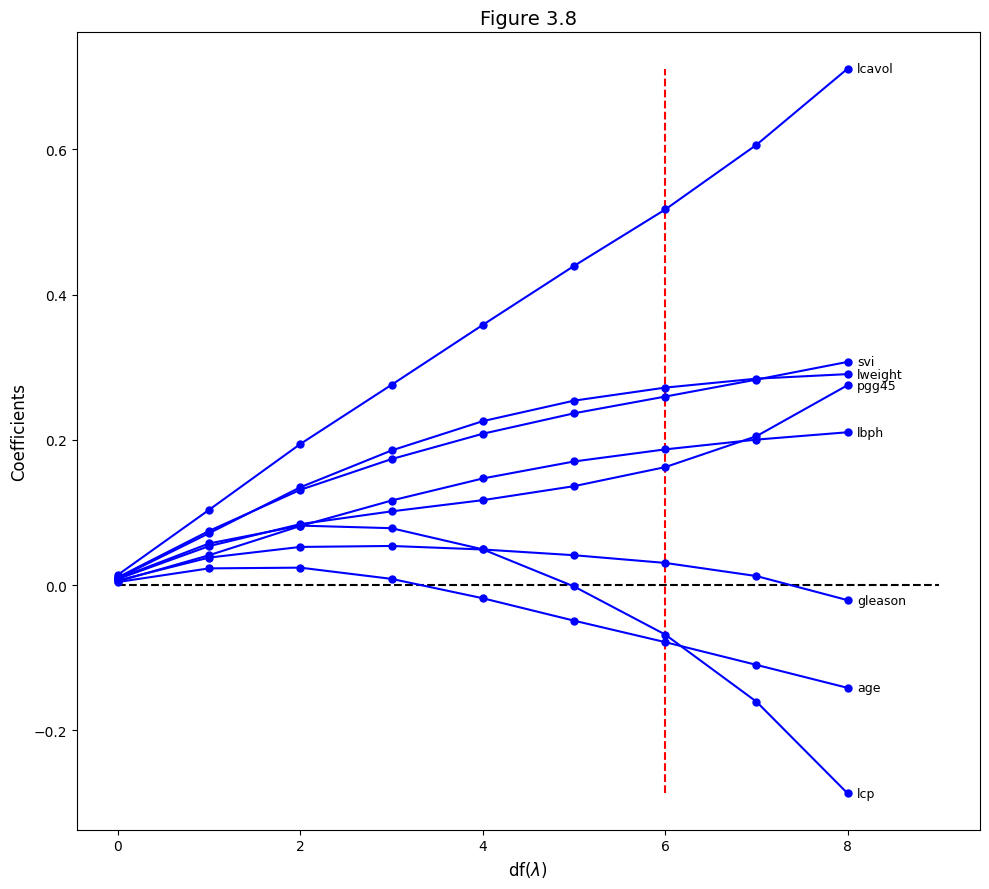

In [13]:
'''Getting the Transpose so it is easier to plot'''

RIDGE_COEF_T = RIDGE_COEF.T
plt.figure(figsize=(10, 9))
'''For the vertical Red Dotted Line'''
min_val = float('inf')
for i in range(len(RIDGE_COEF_T)):
    if min(RIDGE_COEF_T[i]) < min_val:
        min_val = min(RIDGE_COEF_T[i])
max_val = float('-inf')
for i in range(len(RIDGE_COEF_T)):
    if max(RIDGE_COEF_T[i]) > max_val:
        max_val = max(RIDGE_COEF_T[i])
plt.vlines(RIDGE_VERTICAL_LINE, ymin = min_val, ymax = max_val, color = 'red', linestyles='--')
'''For the horizontal Black Dotted Line'''
plt.hlines(0,xmin=X_AXIS_RIDGE[0], xmax=X_AXIS_RIDGE[-1]+1, color = 'black', linestyles='--')

'''For The Blue Curves'''
for i in range(len(RIDGE_COEF_T)):
    plt.plot(X_AXIS_RIDGE, RIDGE_COEF_T[i],color = 'blue',marker='o', linestyle='-', markersize=5, markerfacecolor='blue')

    plt.text(X_AXIS_RIDGE[-1]+0.1,RIDGE_COEF_T[i][-1], DATA.columns[i], fontsize=9, verticalalignment='center')

plt.xlabel("df($\lambda$)", fontsize=12)
plt.ylabel("Coefficients", fontsize=12)
plt.title("Figure 3.8", fontsize=14)
plt.tight_layout()
plt.plot()

Figure 3.10

[]

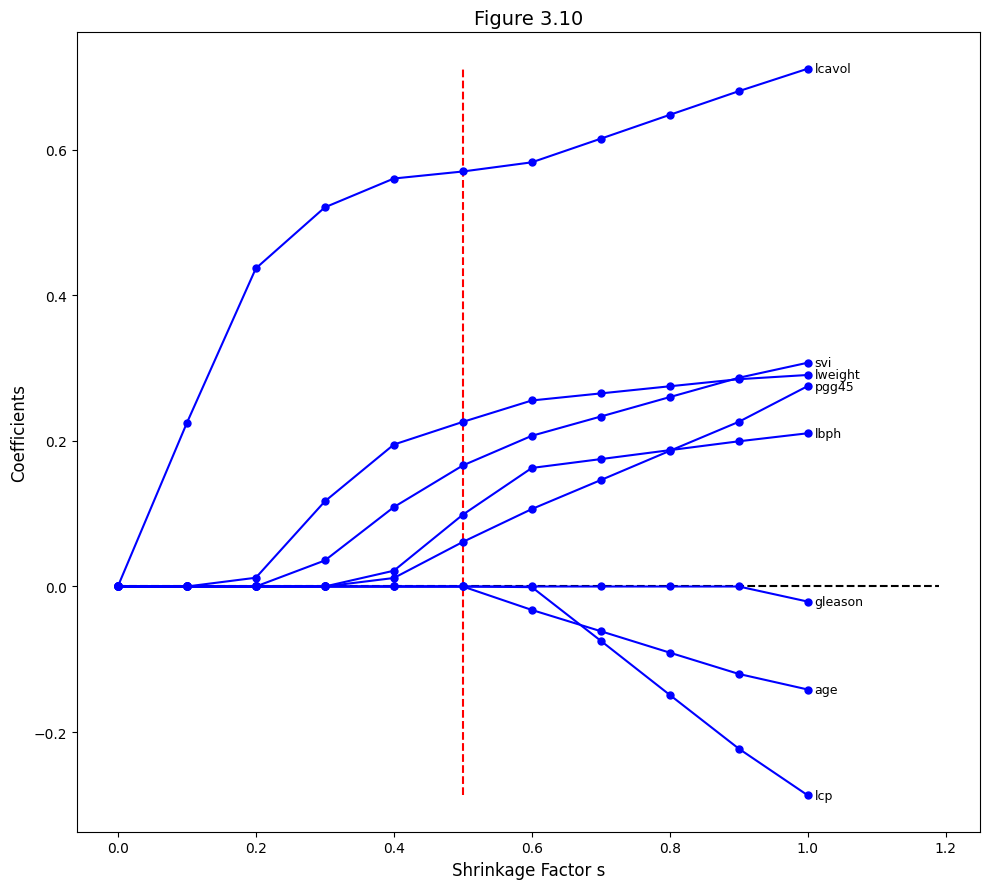

In [14]:
'''Getting the Transpose so it is easier to plot'''

LASSO_COEF_T = LASSO_COEF.T
plt.figure(figsize=(10,9))

'''For the vertical Red Dotted Line'''
min_val = float('inf')
for i in range(len(LASSO_COEF_T)):
    if min(LASSO_COEF_T[i]) < min_val:
        min_val = min(LASSO_COEF_T[i])
max_val = float('-inf')
for i in range(len(LASSO_COEF_T)):
    if max(LASSO_COEF_T[i]) > max_val:
        max_val = max(LASSO_COEF_T[i])
plt.vlines(LASSO_VERTICAL_LINE, ymin = min_val, ymax = max_val, color = 'red', linestyles='--')
'''For the horizontal Black Dotted Line'''
plt.hlines(0,xmin=X_AXIS_LASSO[0], xmax=X_AXIS_LASSO[-1]+0.19, color = 'black', linestyles='--')

'''For The Blue Curves'''
for i in range(len(LASSO_COEF_T)):
    plt.plot(X_AXIS_LASSO, LASSO_COEF_T[i],color = 'blue',marker='o', linestyle='-', markersize=5, markerfacecolor='blue')

    plt.text(X_AXIS_LASSO[-1]+0.01,LASSO_COEF_T[i][-1], DATA.columns[i], fontsize=9, verticalalignment='center')

plt.xlabel("Shrinkage Factor s", fontsize=12)
plt.ylabel("Coefficients", fontsize=12)
plt.title("Figure 3.10", fontsize=14)
plt.tight_layout()
plt.plot()
